### Import necessary libraries and modules

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import zscore
from itertools import combinations
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.metrics import silhouette_score, davies_bouldin_score, make_scorer
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from mlxtend.frequent_patterns import apriori
from itertools import combinations

### Load the dataset and inspect the original dataset

In [2]:
# Specify the file path
file_path = "03. [DAZONE2024] DATASET.csv"

# Load the file into a dataframe
data = pd.read_csv(file_path)
df = pd.DataFrame(data)

# Inspect the structure of the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3069 entries, 0 to 3068
Data columns (total 31 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   ID                     3069 non-null   int64  
 1   Year_Of_Birth          2832 non-null   float64
 2   Academic_Level         2799 non-null   object 
 3   Income                 2782 non-null   float64
 4   Registration_Time      2824 non-null   object 
 5   Recency                2804 non-null   float64
 6   Liquor                 2807 non-null   float64
 7   Vegetables             2810 non-null   float64
 8   Pork                   2806 non-null   float64
 9   Seafood                2813 non-null   float64
 10  Candy                  2840 non-null   float64
 11  Jewellery              2792 non-null   float64
 12  Num_Deals_Purchases    2841 non-null   float64
 13  Num_Web_Purchases      2823 non-null   float64
 14  Num_Catalog_Purchases  2811 non-null   float64
 15  Num_

## Step 1:
### Data Understanding, Data Cleaning and Data Preprocessing
##### In this step, we will:
* Handle missing values, duplicates
* Transform data (change data types, create new variables) for consistency

In [3]:
# Check for missing values, data types, and summary statistics
missing_values = df.isnull().sum()
data_types = df.dtypes
summary_stats = df.describe(include='all')

# Display missing values, data types, and summary statistics
missing_values, data_types, summary_stats

(ID                          0
 Year_Of_Birth             237
 Academic_Level            270
 Income                    287
 Registration_Time         245
 Recency                   265
 Liquor                    262
 Vegetables                259
 Pork                      263
 Seafood                   256
 Candy                     229
 Jewellery                 277
 Num_Deals_Purchases       228
 Num_Web_Purchases         246
 Num_Catalog_Purchases     258
 Num_Store_Purchases       243
 Num_Web_Visits_Month      270
 Promo_30                  243
 Promo_40                  254
 Promo_50                  268
 Promo_10                  235
 Promo_20                  243
 Complain                  256
 Gender                    275
 Phone                    1508
 Phone_Number             1812
 Year_Register             985
 Month_Register            969
 Total_Purchase            236
 Living_With               248
 Payment_Method            799
 dtype: int64,
 ID                     

### Observations from the Data Exploration:
1. Missing Values:
* Several columns have significant missing values, e.g., Phone_Number, Phone, Payment_Method, Year_Register, and others.
* Missing data handling will be critical for columns relevant to clustering.

2. Data Types:
* Year_Of_Birth, Year_Register, and Month_Register should be numeric.

3. Potential Outliers:
* High variance in spending columns (e.g., Liquor, Pork, Seafood) and Income suggests potential outliers.

4. Feature Engineering Opportunities:
* Derive Age from Year_Of_Birth.
* Calculate Total_Spending by summing spending categories (e.g., Liquor, Vegetables, etc.).

In [4]:
# Merge rows with the same ID by filling missing values across columns
df = df.sort_values("ID")
df = df.groupby('ID').apply(lambda x: x.ffill().bfill()).drop_duplicates()

C:\Users\admin\AppData\Local\Temp\ipykernel_20460\1418293259.py:3: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.groupby('ID').apply(lambda x: x.ffill().bfill()).drop_duplicates()
C:\Users\admin\AppData\Local\Temp\ipykernel_20460\1418293259.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby('ID').apply(lambda x: x.ffill().bfill()).drop_duplicates()


In [5]:
# Drop the specified columns
df.drop(columns=['ID', 'Phone', 'Phone_Number', 'Year_Register', 'Month_Register'], inplace=True)

In [6]:
# Create 'Age' from 'Year_Of_Birth'
current_year = 2025
df['Age'] = current_year - df['Year_Of_Birth']

# Drop 'Year_Of_Birth' as 'Age' replaces it
df = df.drop(columns=['Year_Of_Birth'])

In [7]:
# Create 'Total_Spending' by summing spending categories
spending_columns = ['Liquor', 'Vegetables', 'Pork', 'Seafood', 'Candy', 'Jewellery']
df['Total_Spending'] = df[spending_columns].sum(axis=1)

In [8]:
# Living_With: Split into "Marital Status" and "Num_Of_Child"
df[['Marital_Status', 'Num_Of_Child']] = df['Living_With'].str.split('_', expand=True)
df = df.drop(columns=['Living_With'])

In [9]:
# Payment_Method: Fill missing values with "Not Provided"
df['Payment_Method'] = df['Payment_Method'].fillna("Not Provided")

In [10]:
# Drop missing values
df.dropna(inplace=True)

# Find the maximum value in the Income column and drop the corresponding row
max_income = df['Income'].max()
df = df[df['Income'] != max_income]

In [11]:
columns_to_convert = [
    'Income', 'Recency', 'Liquor', 'Vegetables', 'Pork', 'Seafood', 'Candy', 
    'Jewellery', 'Num_Deals_Purchases', 'Num_Web_Purchases', 
    'Num_Catalog_Purchases', 'Num_Store_Purchases', 'Num_Web_Visits_Month', 
    'Promo_30', 'Promo_40', 'Promo_50', 'Promo_10', 'Promo_20', 'Complain', 
    'Total_Purchase', 'Age', 'Total_Spending'
]

# Convert the selected columns to int64
df[columns_to_convert] = df[columns_to_convert].astype('int64')

In [12]:
# Remove rows where 'Marital_Status' is 'YOLO' or 'Absurd'
df = df[~df['Marital_Status'].isin(['YOLO', 'Absurd'])]

# Replace 'Alone' with 'Single'
df['Marital_Status'] = df['Marital_Status'].replace('Alone', 'Single')

In [13]:
# Do a final check after cleaning using the info() method
df.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 2211 entries, (1001, 831) to (9997, 2846)
Data columns (total 28 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   Academic_Level         2211 non-null   object
 1   Income                 2211 non-null   int64 
 2   Registration_Time      2211 non-null   object
 3   Recency                2211 non-null   int64 
 4   Liquor                 2211 non-null   int64 
 5   Vegetables             2211 non-null   int64 
 6   Pork                   2211 non-null   int64 
 7   Seafood                2211 non-null   int64 
 8   Candy                  2211 non-null   int64 
 9   Jewellery              2211 non-null   int64 
 10  Num_Deals_Purchases    2211 non-null   int64 
 11  Num_Web_Purchases      2211 non-null   int64 
 12  Num_Catalog_Purchases  2211 non-null   int64 
 13  Num_Store_Purchases    2211 non-null   int64 
 14  Num_Web_Visits_Month   2211 non-null   int64 
 15  Pro

In [14]:
# Save the newly cleaned dataset to a CSV file
df.to_csv("03. [DAZONE2024] CLEANED DATASET.csv", index=None)

## Step 2: EDA (Exploratory Data Analysis)
### Goals for EDA:
1. Understand Data Distribution:
* Visualize numerical features (e.g., histograms, box plots).
* Analyze categorical feature distributions (e.g., bar plots).

2. Feature Correlations:
* Compute and visualize correlations among numerical variables.

3. Outlier Analysis:
* Detect and examine potential outliers in key numerical features.

4. Customer Segmentation Potential:
* Evaluate clustering potential using dimensionality reduction techniques like PCA.

In [15]:
# Specify the file path
file_path1 = "03. [DAZONE2024] CLEANED DATASET.csv"

# Load the file into a dataframe
df1 = pd.read_csv(file_path1)

# Display basic information about the dataset
df1.info(), df1.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2211 entries, 0 to 2210
Data columns (total 28 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   Academic_Level         2211 non-null   object
 1   Income                 2211 non-null   int64 
 2   Registration_Time      2211 non-null   object
 3   Recency                2211 non-null   int64 
 4   Liquor                 2211 non-null   int64 
 5   Vegetables             2211 non-null   int64 
 6   Pork                   2211 non-null   int64 
 7   Seafood                2211 non-null   int64 
 8   Candy                  2211 non-null   int64 
 9   Jewellery              2211 non-null   int64 
 10  Num_Deals_Purchases    2211 non-null   int64 
 11  Num_Web_Purchases      2211 non-null   int64 
 12  Num_Catalog_Purchases  2211 non-null   int64 
 13  Num_Store_Purchases    2211 non-null   int64 
 14  Num_Web_Visits_Month   2211 non-null   int64 
 15  Promo_30             

(None,
   Academic_Level  Income Registration_Time  Recency  Liquor  Vegetables  Pork  \
 0     Graduation   61074        17-08-2021       37     790           2   133   
 1     Graduation   60093        26-06-2022       92     503          14   109   
 2       2n Cycle   79689        12-05-2022       65     312          28   640   
 3         Master   41021        30-12-2021       12      15           9     9   
 4            PhD   57333        22-09-2021       55     942          16   397   
 
    Seafood  Candy  Jewellery  ...  Promo_10  Promo_20  Complain  Gender  \
 0        0     28        152  ...         0         0         0   Other   
 1       16      6         90  ...         0         0         0    Male   
 2      180     37        121  ...         0         0         0  Female   
 3        6     16         12  ...         0         0         0  Female   
 4       76     58        176  ...         0         0         0    Male   
 
    Total_Purchase  Payment_Method  Age  

#### The dataset consists of 2,211 entries and 28 columns, covering various customer attributes such as demographics, purchasing behavior, and promotional responses.

Outline of the planned exploratory data analysis (EDA) steps to uncover valuable insights aligned with the goal of customer profiling:

1. Data Understanding
* Overview of data types and missing values.
* Summary statistics to understand the distribution of numerical features.
* Analysis of categorical features' unique values and distributions.

2. Statistical Analysis
* Correlation analysis to identify relationships between spending habits, promotions, and purchasing channels.
* Distribution analysis of key numerical features such as Age, Total_Spending, and Recency.
* Outlier detection using box plots and Z-scores.
* Customer segmentation based on total spending and purchasing behavior.

3. Feature-Specific Analysis
* Spending patterns across different categories (Liquor, Vegetables, Pork, etc.).
* Customer behavior based on promotions accepted.
* Analysis of purchasing behavior by payment method and registration time.
* Relationship between marital status, number of children, and spending habits.

4. Visualization
* Bar charts for categorical variables like Gender, Marital_Status, Payment_Method.
* Distribution plots and histograms for numerical variables.
* Heatmaps to visualize correlations between key numerical features.
* Boxplots to detect spending variation across different customer segments.

5. Customer Segmentation Insights
* Clustering analysis to segment customers based on total spending and buying preferences.
* Potential grouping based on demographic characteristics such as age, marital status, and academic level.
* Evaluation of promotional campaign effectiveness for different segments

In [16]:
# Statistical summary of numerical features
numerical_summary = df1.describe()

# Summary of categorical features
categorical_columns = df1.select_dtypes(include=['object']).columns
categorical_summary = df1[categorical_columns].nunique()

# Check for missing values
missing_values = df1.isnull().sum()

numerical_summary, categorical_summary, missing_values

(              Income      Recency       Liquor   Vegetables         Pork  \
 count    2211.000000  2211.000000  2211.000000  2211.000000  2211.000000   
 mean    51954.612393    49.062415   306.164631    28.330167   167.037540   
 std     21535.791745    28.942034   337.628884    39.789929   224.373315   
 min      1730.000000     0.000000     1.000000     2.000000     0.000000   
 25%     35221.000000    24.000000    25.000000     3.500000    16.000000   
 50%     51373.000000    49.000000   175.000000    10.000000    68.000000   
 75%     68487.000000    74.000000   507.000000    35.000000   232.500000   
 max    162397.000000    99.000000  1494.000000   201.000000  1725.000000   
 
            Seafood        Candy    Jewellery  Num_Deals_Purchases  \
 count  2211.000000  2211.000000  2211.000000          2211.000000   
 mean     37.529625    27.059249    43.836725             2.320669   
 std      54.567401    41.098014    51.630711             1.923614   
 min       0.000000     0

### Initial Findings from the Data Exploration:
1. Numerical Feature Summary:
* Income:

+) Mean: 51,969, Range: 1,730 - 162,397

+) High variability, indicating diverse customer income levels.


* Recency (days since last purchase):

+) Mean: 49 days, Range: 0 - 99 days.

+) Some customers are highly active, while others are disengaged.


* Total Spending:

+) Mean: 610, Range: 8 - $2,528.

+) Skewed distribution suggests the presence of high-spending customers.


* Purchasing Behavior:

Total Purchases: Mean = 14.88, Max = 44 purchases.

Website purchases range from 0 to 27, catalog purchases from 0 to 15.


* Promotions Acceptance:

Campaign acceptance is generally low across all campaigns (Promo_10 to Promo_50).


2. Categorical Feature Summary:
* Gender: 3 unique values (Male, Female, Other).
* Marital Status: 8 categories (e.g., Single, Married, Divorced).
* Payment Methods: 5 types, indicating diverse payment preferences.
* Academic Level: 5 categories (Graduation, Master, PhD, etc.).
* Registration Time: 662 unique values, suggesting a broad range of customer acquisition periods.


3. Missing Values:
* No missing values were found in the dataset, making it well-prepared for further analysis.

### Next Steps:
1. Visual Exploration:
* Analyze customer distribution by age, income, and spending.
* Evaluate purchasing behavior across channels.
* Explore trends based on marital status, academic levels, and payment methods.

2. Correlation Analysis:
* Assess the relationships between income, spending, and promotional acceptance.

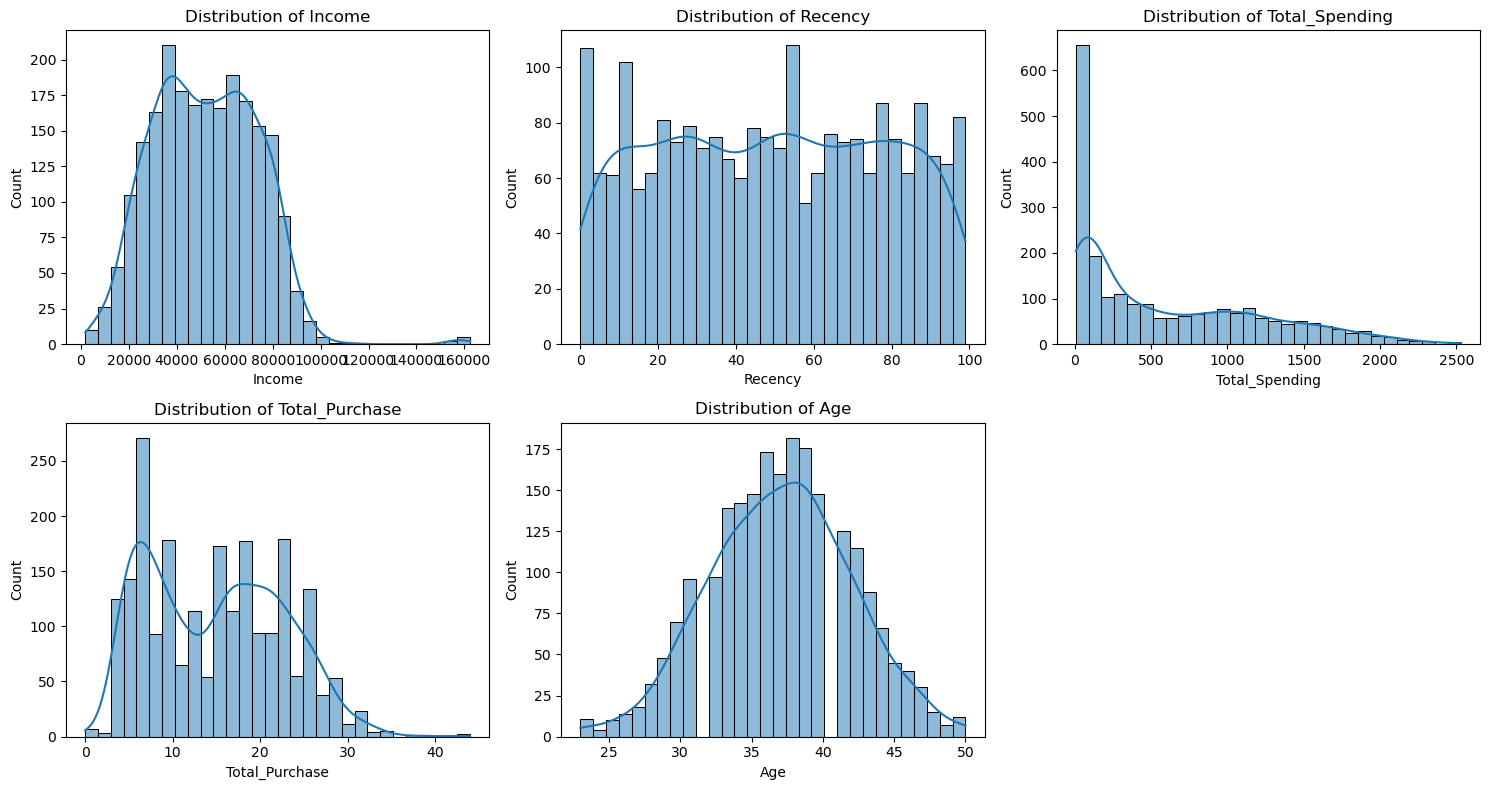

In [17]:
# Distribution of key numerical features
numerical_features = ['Income', 'Recency', 'Total_Spending', 'Total_Purchase', 'Age']

# Plot histograms
plt.figure(figsize=(15, 8))
for i, feature in enumerate(numerical_features, 1):
    plt.subplot(2, 3, i)
    sns.histplot(df1[feature], kde=True, bins=30)
    plt.title(f'Distribution of {feature}')
plt.tight_layout()
plt.show()

C:\Users\admin\AppData\Local\Temp\ipykernel_20460\1904444161.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df1[feature], order=df1[feature].value_counts().index, palette="viridis")
C:\Users\admin\AppData\Local\Temp\ipykernel_20460\1904444161.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df1[feature], order=df1[feature].value_counts().index, palette="viridis")
C:\Users\admin\AppData\Local\Temp\ipykernel_20460\1904444161.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df1[feature], order=df1[feature].value_counts().

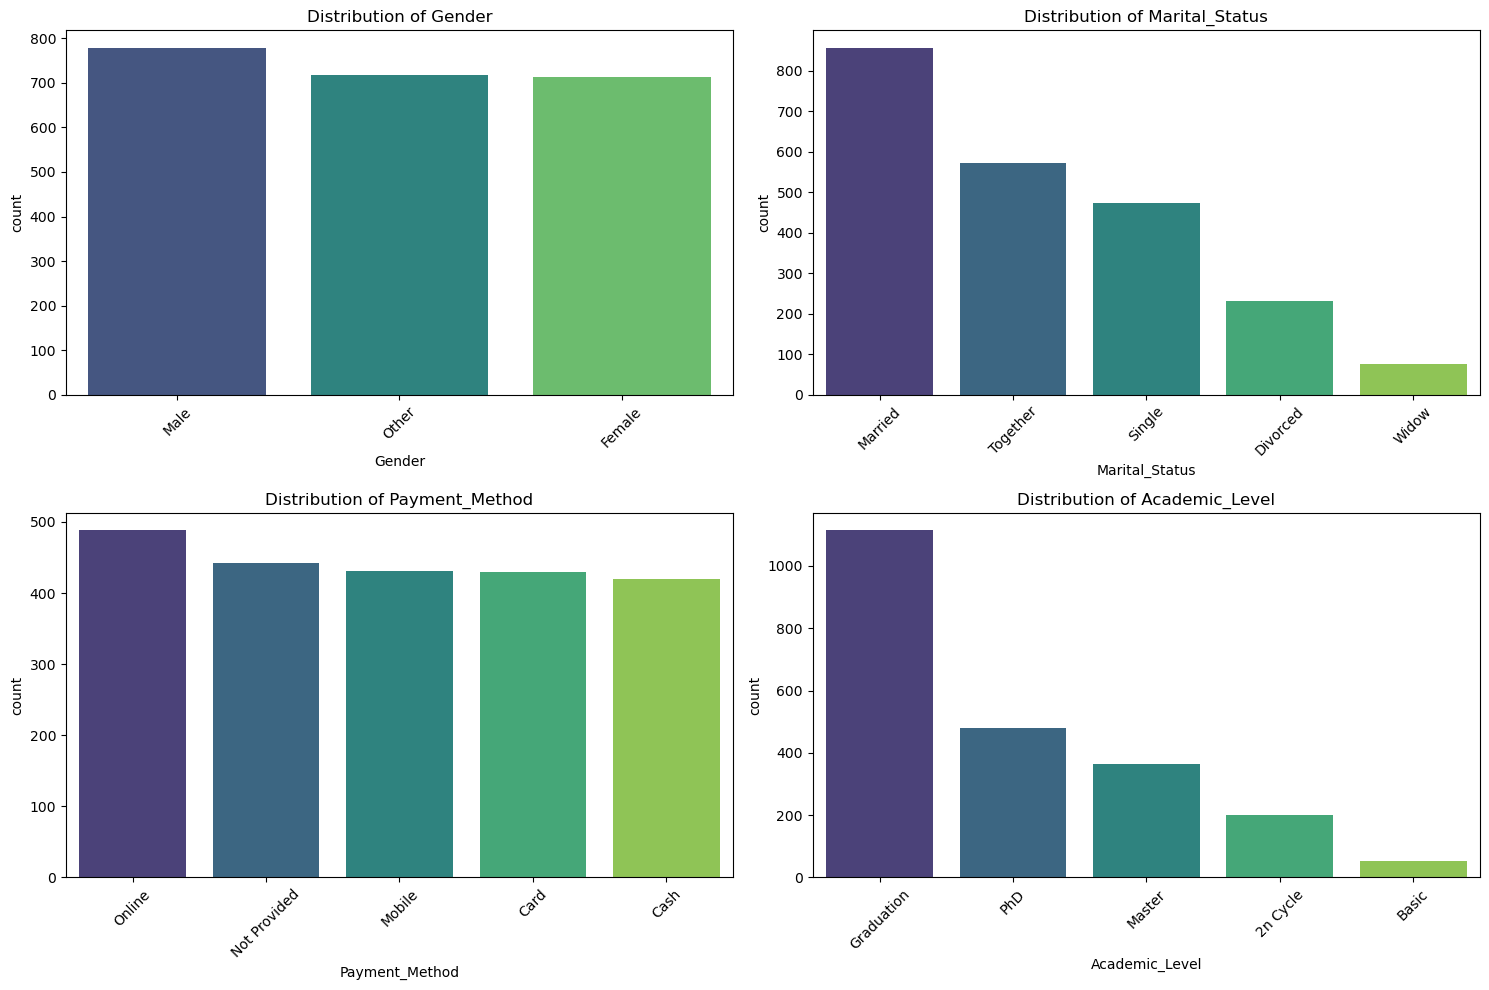

In [18]:
# Categorical distribution analysis
categorical_features = ['Gender', 'Marital_Status', 'Payment_Method', 'Academic_Level']

plt.figure(figsize=(15, 10))
for i, feature in enumerate(categorical_features, 1):
    plt.subplot(2, 2, i)
    sns.countplot(x=df1[feature], order=df1[feature].value_counts().index, palette="viridis")
    plt.title(f'Distribution of {feature}')
    plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

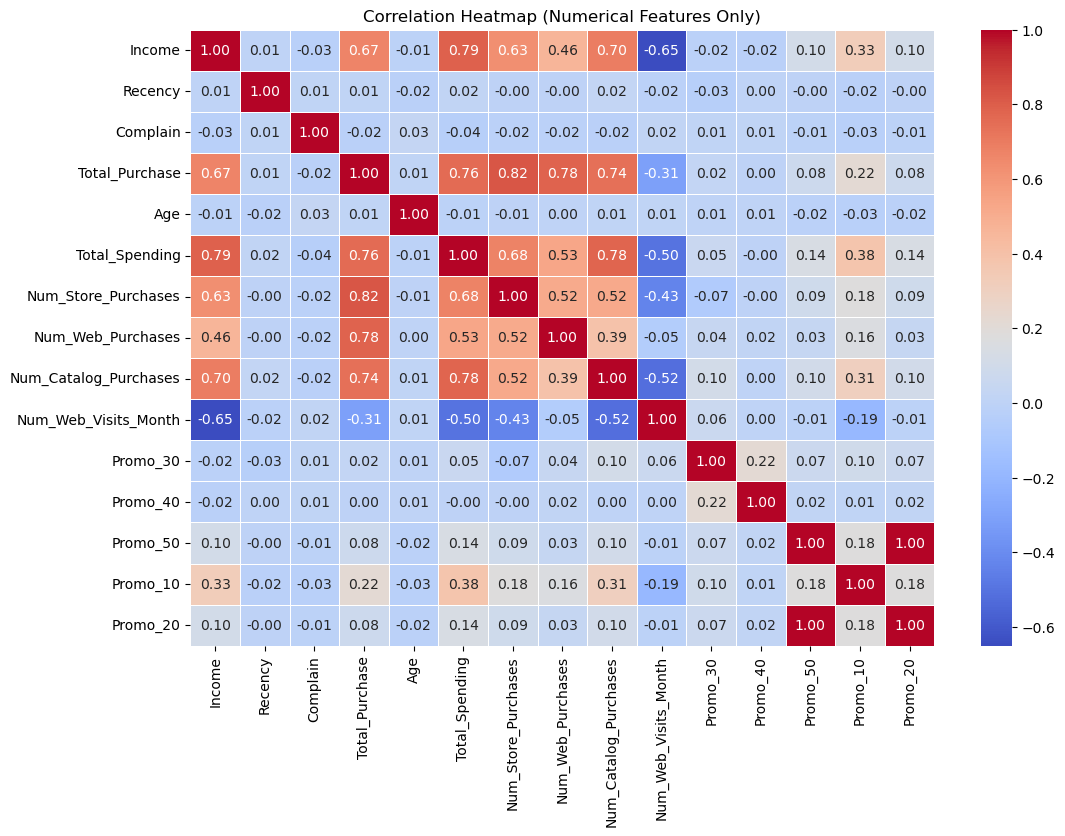

In [19]:
# Select only numerical columns with correct syntax
target_df = df1[['Income', 'Recency', 'Complain', 'Total_Purchase', 'Age',
                   'Total_Spending', 'Num_Store_Purchases', 'Num_Web_Purchases',
                   'Num_Catalog_Purchases', 'Num_Web_Visits_Month', 'Promo_30', 
                   'Promo_40', 'Promo_50', 'Promo_10', 'Promo_20']]

# Compute correlation matrix
corr_matrix = target_df.corr()

# Plot the correlation heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap (Numerical Features Only)')
plt.show()

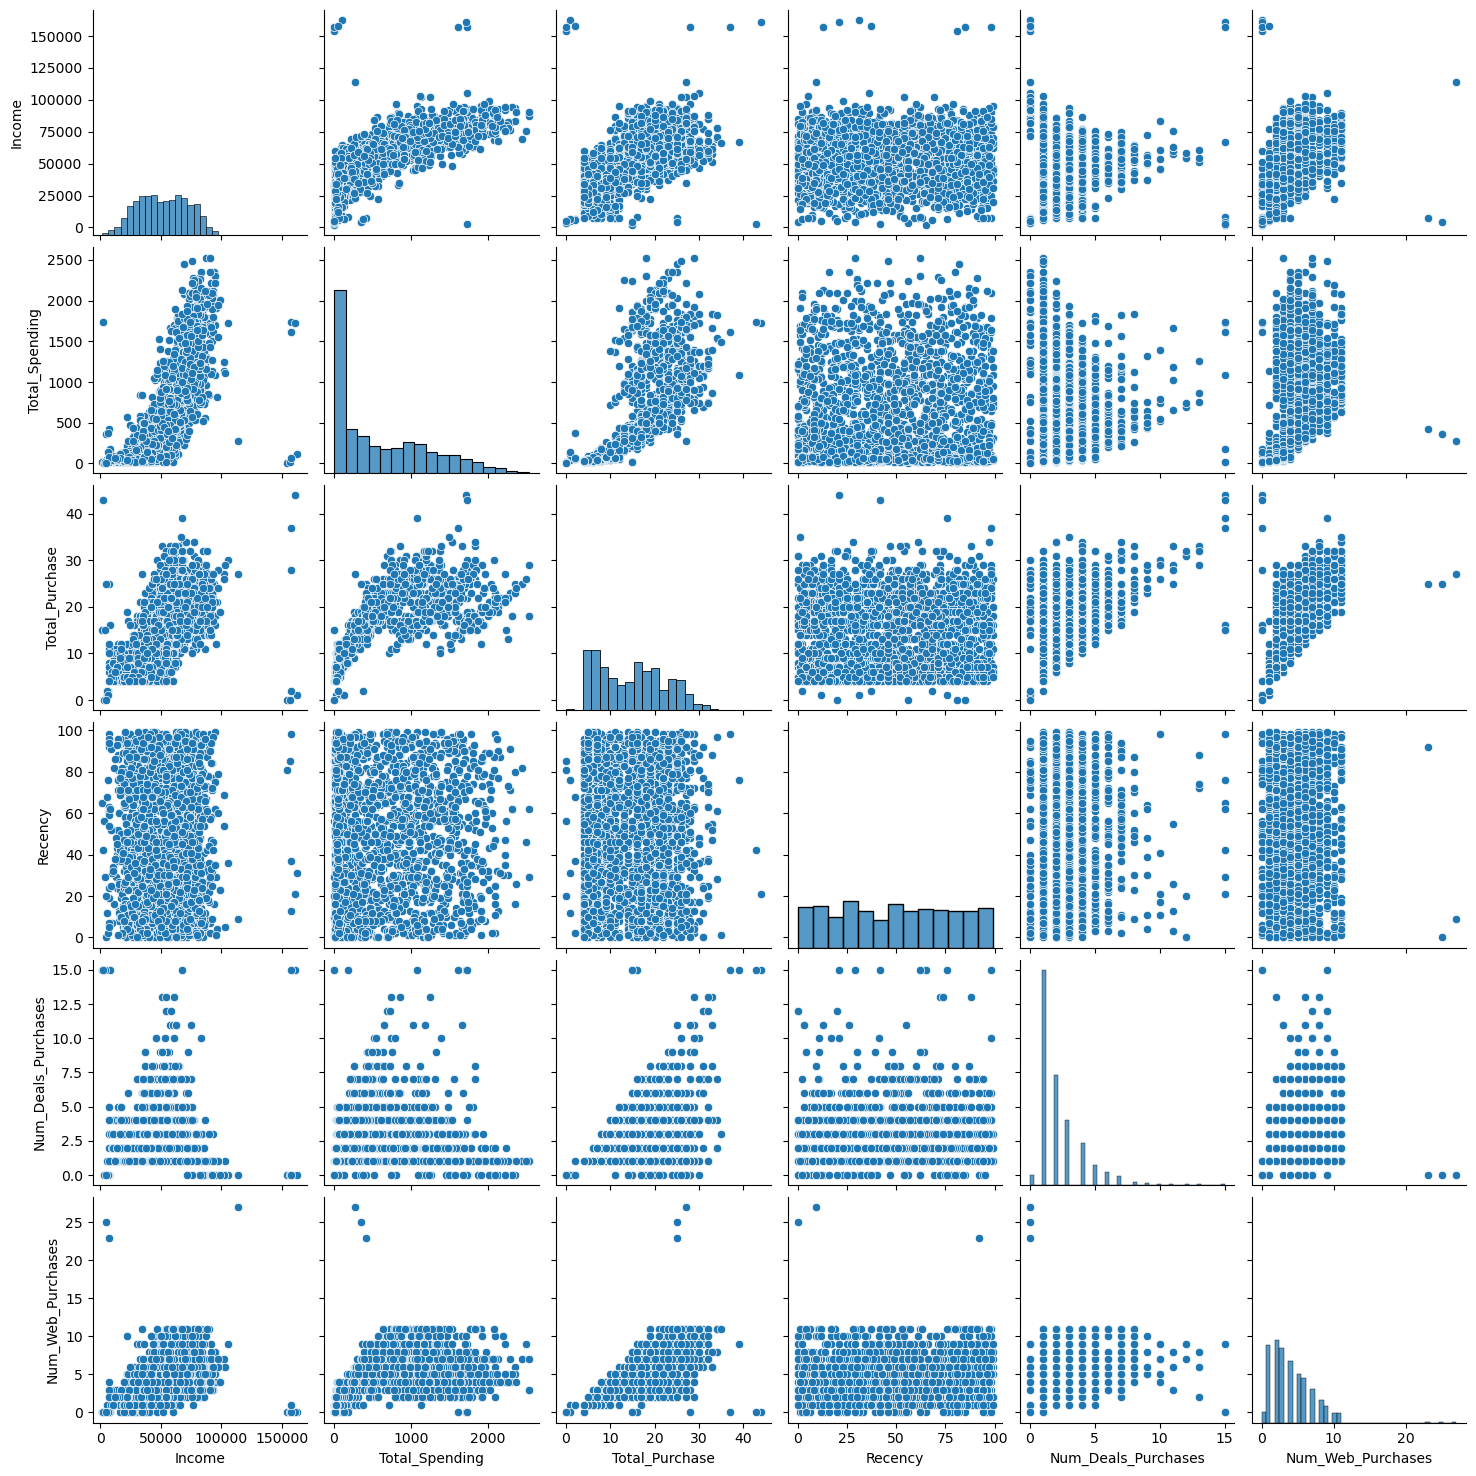

In [20]:
# Pair plot for selected important features
selected_features_pairplot = [
    'Income', 'Total_Spending', 'Total_Purchase', 
    'Recency', 'Num_Deals_Purchases', 'Num_Web_Purchases'
]

sns.pairplot(df1[selected_features_pairplot])
plt.show()

### Insights from Visual Exploration:
1. Numerical Feature Distributions:
* `Income`:<br>
+) The majority of customers have an income between 30,000 and 70,000.<br>
+) The distribution is right-skewed, indicating the presence of a few high-income individuals.<br>
+) Insight: Marketing efforts can be tailored to target both middle and high-income customers separately.

* `Recency`:<br>
+) A significant portion of customers haven't purchased recently (high recency values), which could indicate churn risks.<br>
+) Insight: Strategies should focus on re-engagement campaigns for customers with high recency values.

* `Total_Spending`:<br>
+) Highly skewed distribution, with a large number of customers having low spending and a few contributing to high total spending.<br>
+) Insight: Premium offerings can be targeted toward high-spending customers, while loyalty programs can encourage higher spending for low-tier customers.

* `Age`:<br>
+) The majority of customers are between 30 and 40 years old, with fewer customers above 40.<br>
+) Insight: Targeting should prioritize the 30-40 age group with products and services relevant to their lifestyle.
<br><br><br>

2. Categorical Feature Analysis:
* `Gender`:<br>
+) The dataset is balanced with a slight male dominance, "Other" and "Female" has the similar frequency <br>
+) Insight: Gender-specific marketing strategies may help optimize product offerings.

* `Marital Status`:<br>
+) "Married" customers dominate, followed by "Together" and "Single" categories.<br>
+) Potential differences in spending behavior across marital statuses.<br>
+) Insight: Bundle deals and family-oriented promotions can be targeted toward married customers.

* `Payment_Method`:<br>
+) All payment types has relatively similar frequency, indicating that we cannot use payment method to find potential customer

* `Academic_Level`:<br>
+) Majority of customers hold "Graduation" degrees, which can be used to tailor promotional content.<br>
+) Insight: High-education level customers may respond better to value-based product offerings rather than discount-driven promotions.
<br><br><br>

3. Correlation Analysis:
* Strong Positive Correlations:<br>
+) `Total_Spending` has a high correlation with `Total_Purchase`, confirming that more purchases generally lead to higher spending.<br>
+) `Num_Store_Purchases` and `Total_Purchase` show a strong correlation, indicating that store purchases significantly contribute to total purchases.<br>
+) `Num_Web_Purchases` and `Num_Catalog_Purchases` are also positively correlated, suggesting customers who purchase online tend to use catalogs frequently.<br>
+) `Income` has a strong correlation with `Total_Spending`, meaning spending habits may be driven by income levels.

* Weak or No Correlation:<br>
+) Promotional acceptance rates (Promo_10 to Promo_50) show weak correlations with spending, suggesting promotions are not effectively converting into sales.

* Strong Negative Correlations:<br>
+) `Num_Web_Visit_Month` and `Income` that a strong negative orrelation, indicating that people with lower income tend not to go shopping online and tend not to go shopping as often
<br>
### Key Takeaway:
#### Businesses should focus on recent, high-purchasing customers for targeted marketing, while revisiting the effectiveness of current promotional campaigns.

C:\Users\admin\AppData\Local\Temp\ipykernel_20460\2867756047.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Age_Group', y='Total_Spending', data=df1, palette='viridis')


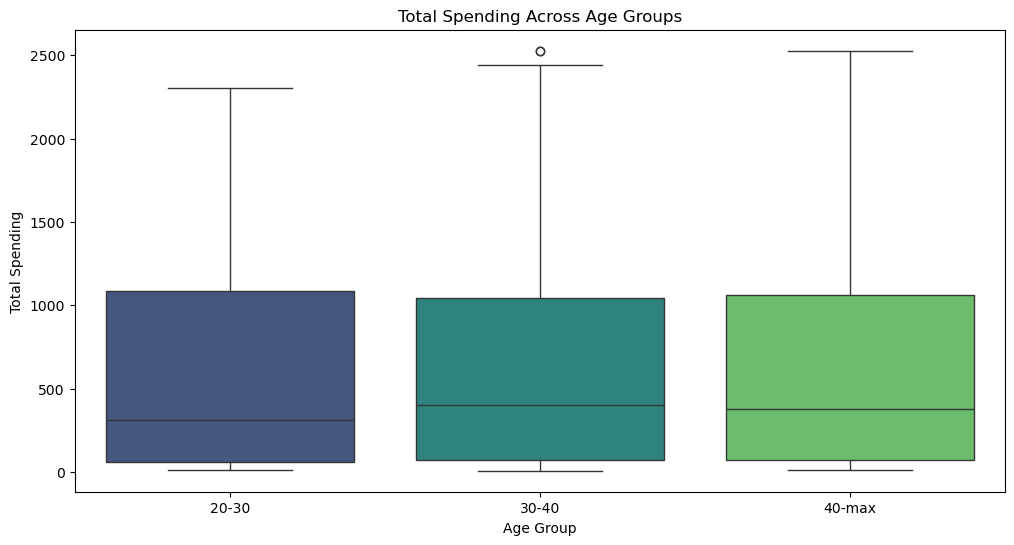

In [21]:
# Visualization of spending trends across age groups, marital status, and payment methods
# Age Group Analysis
df1['Age_Group'] = pd.cut(df1['Age'], bins=[20, 30, 40, df1['Age'].max()], labels=['20-30', '30-40', '40-max'])

# Plot spending trends across age groups
plt.figure(figsize=(12, 6))
sns.boxplot(x='Age_Group', y='Total_Spending', data=df1, palette='viridis')
plt.title('Total Spending Across Age Groups')
plt.xlabel('Age Group')
plt.ylabel('Total Spending')
plt.show()

C:\Users\admin\AppData\Local\Temp\ipykernel_20460\4125030237.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Marital_Status', y='Total_Spending', data=df1, palette='muted', order=df1['Marital_Status'].value_counts().index)


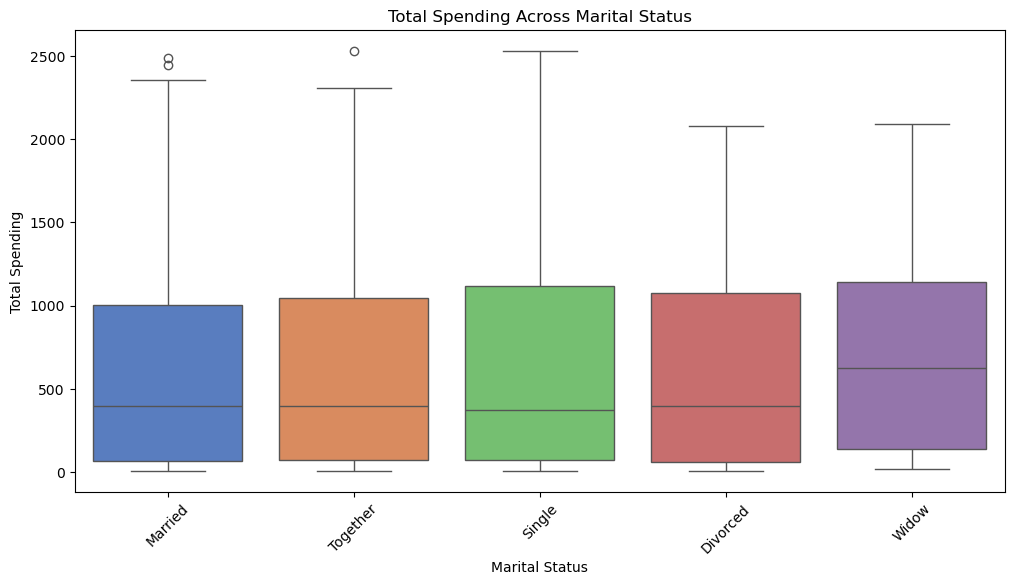

In [22]:
# Marital Status Analysis
plt.figure(figsize=(12, 6))
sns.boxplot(x='Marital_Status', y='Total_Spending', data=df1, palette='muted', order=df1['Marital_Status'].value_counts().index)
plt.title('Total Spending Across Marital Status')
plt.xlabel('Marital Status')
plt.ylabel('Total Spending')
plt.xticks(rotation=45)
plt.show()

C:\Users\admin\AppData\Local\Temp\ipykernel_20460\2503027605.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Payment_Method', y='Total_Spending', data=df1, palette='coolwarm', order=df1['Payment_Method'].value_counts().index)


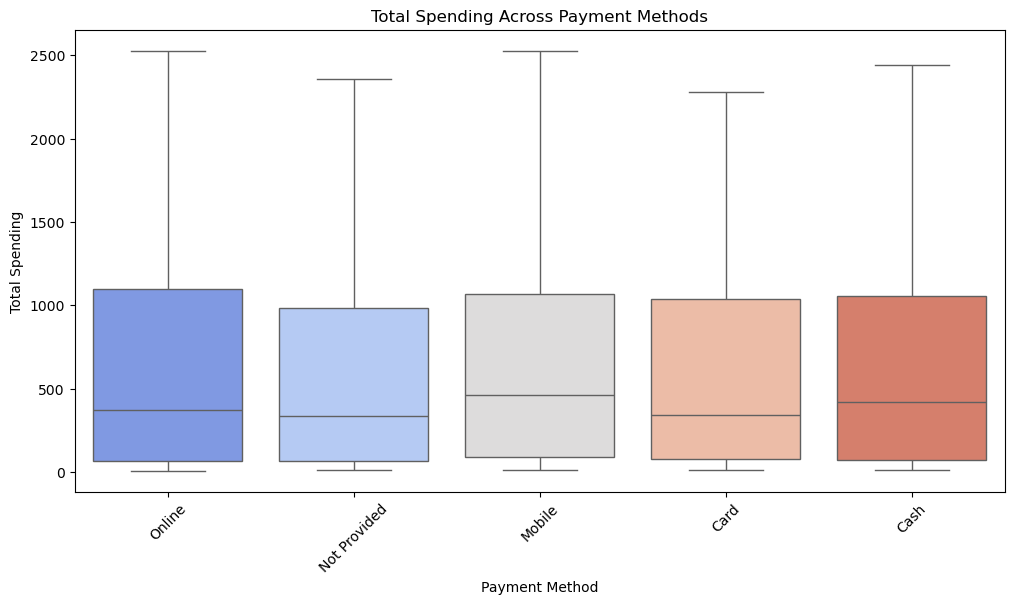

In [23]:
# Payment Method Analysis
plt.figure(figsize=(12, 6))
sns.boxplot(x='Payment_Method', y='Total_Spending', data=df1, palette='coolwarm', order=df1['Payment_Method'].value_counts().index)
plt.title('Total Spending Across Payment Methods')
plt.xlabel('Payment Method')
plt.ylabel('Total Spending')
plt.xticks(rotation=45)
plt.show()

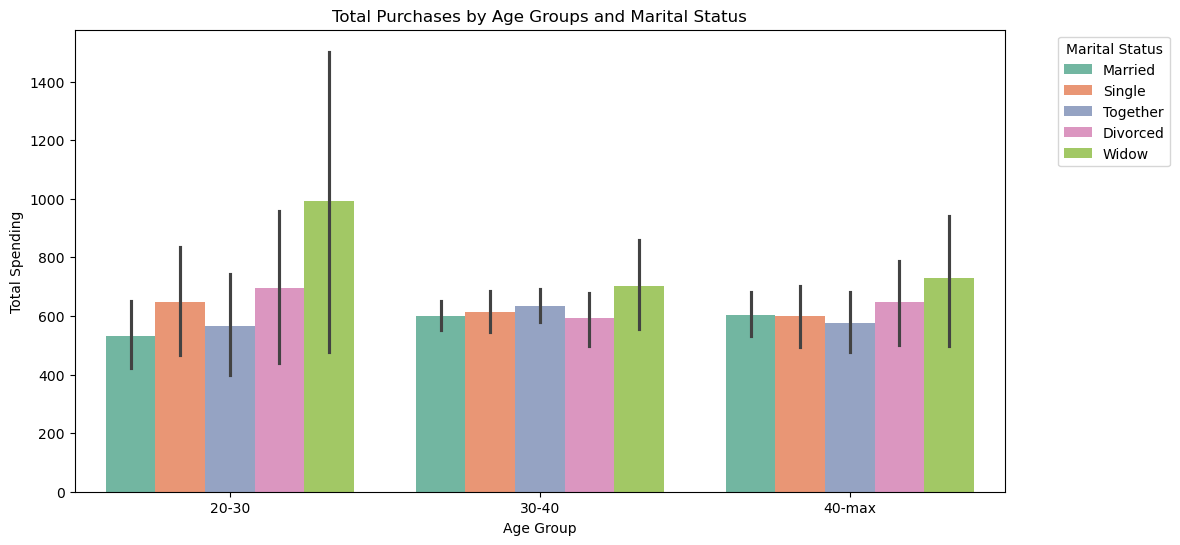

In [24]:
# Analyze purchase preferences across age groups and marital statuses
plt.figure(figsize=(12, 6))
sns.barplot(x='Age_Group', y='Total_Spending', hue='Marital_Status', data=df1, palette='Set2')
plt.title('Total Purchases by Age Groups and Marital Status')
plt.xlabel('Age Group')
plt.ylabel('Total Spending')
plt.legend(title='Marital Status', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

### Detailed Insights from the Analysis:
1. Spending Trends Across Age Groups:
* The 30-40 age group exhibits the highest spending, with a relatively narrow interquartile range, indicating consistent spending habits among these customers.
* The 20-30 age group has a lower median spending and a wider range of spending values, suggesting diverse purchasing behavior, possibly influenced by financial constraints or lifestyle choices.
* The 40-max age group shows a broader spread in spending, indicating a mix of both high and low spenders. This group may include retirees or financially stable individuals who spend selectively.

* Business Implication:<br>
+) Focus marketing efforts on the 30-40 age group with premium product offerings and loyalty programs.<br>
+) Offer budget-friendly or installment-based purchasing options for younger customers.<br>
+) Segment the 40-max group further to target high-value customers with personalized services.
<br><br><br>

2. Spending Patterns Across Marital Status:
* "Married" and "Together" customers spend significantly more compared to single or divorced customers.
* The "Widowed" and "Alone" groups have lower spending, potentially due to financial limitations or different consumption needs.
* High variability in spending is observed for the "Together" category, suggesting different household financial structures.
* Business Implication:<br>
+) Target married customers with bundle offers and family-oriented promotions.<br>
+) Provide tailored discounts for single individuals to encourage higher spending.<br>
+) Consider financial planning products for widowed and divorced customers.
<br><br><br>

3. Spending Trends Across Payment Methods:
* Customers using credit cards have the highest spending, showing a clear preference for this method in larger transactions.
* Online payment methods are also popular but have a slightly lower spending range compared to card users.
* Mobile payments have the lowest spending values, indicating that customers using this method prefer smaller transactions.
* Business Implication:<br>
+) Offer exclusive cashback or rewards for high-value transactions made through credit cards.<br>
+) Improve the mobile payment experience by offering incentives to increase adoption.<br>
+) Leverage online platforms with targeted promotions based on spending behaviors.
<br><br><br>

4. Purchase Preferences Across Age Groups and Marital Status:
* Married customers in the 30-40 age group make the highest number of total purchases.
* Single customers in the 20-30 age group have fewer purchases, indicating lower engagement or purchasing power.
* The 40-max group displays a steady purchasing pattern, with variations across different marital statuses.
* Business Implication:<br>
+) Enhance product personalization for high-purchase groups.<br>
+) Create targeted campaigns to increase engagement for single individuals in younger age groups.<br>
+) Offer senior-friendly services and product options for the 40-max segment.

### Overall Recommendations:
1. Segmentation-Based Marketing:<br>
* Target high-spending customer segments (30-40 years old, married) with exclusive promotions.<br>
* Introduce financial incentives for younger groups to increase their spending.
<br><br>

2. Seasonal Campaigns:<br>
* Leverage peak months to boost sales through targeted campaigns.<br>
* Plan inventory and logistics in advance to handle demand fluctuations.
<br><br>
3. Re-Engagement Strategies:<br>
* Identify customers with high recency values and send them personalized offers.<br>
* Implement retention strategies such as loyalty programs for frequent buyers.
<br><br>
4. Promotion Optimization:<br>
* Redesign promotional campaigns to better align with customer spending habits.<br>
* Use targeted offers for high-value customers based on past purchase patterns.

## Step 3: Model Building for Segmentation and Customer Profiling<br>
### In this step, we will:
1. Preprocessing for Clustering:
* Encode categorical variables.<br>
* Normalize numerical features.<br>
* Determine relevant features for clustering.

2. Clustering with K-Means:
* Use the elbow method and silhouette score to determine the optimal number of clusters.<br>
* Apply K-Means clustering and analyze the results.

3. Churn Prediction:
* Identify target and predictor variables.<br>
* Encode categorical features.<br>
* Split data into training and test sets.<br>
* Train and evaluate a predictive model.

### K-Means Clustering for customer segmentation

In [25]:
# Select relevant features for clustering
clustering_features = [
    'Income', 'Recency', 'Num_Deals_Purchases', 'Num_Web_Purchases',
    'Num_Catalog_Purchases', 'Num_Store_Purchases', 'Num_Web_Visits_Month',
    'Total_Purchase', 'Age', 'Total_Spending', 'Num_Of_Child'
]

# Encode categorical features
categorical_features = ['Gender', 'Payment_Method', 'Marital_Status', 'Academic_Level']
df_encoded = df1.copy()

for col in categorical_features:
    encoder = LabelEncoder()
    df_encoded[col] = encoder.fit_transform(df1[col])

# Combine encoded features with clustering features
df_cluster = df_encoded[clustering_features]

# Standardize the features
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_cluster)

# Reduce dimensionality with PCA for visualization
pca = PCA(n_components=2)
df_pca = pca.fit_transform(df_scaled)

df_pca[:5]

array([[ 2.42021795,  3.41183153],
       [ 1.1782617 ,  0.79157126],
       [ 3.97590977, -0.95127771],
       [-1.98503412, -0.55368753],
       [ 2.74066293,  4.28140951]])

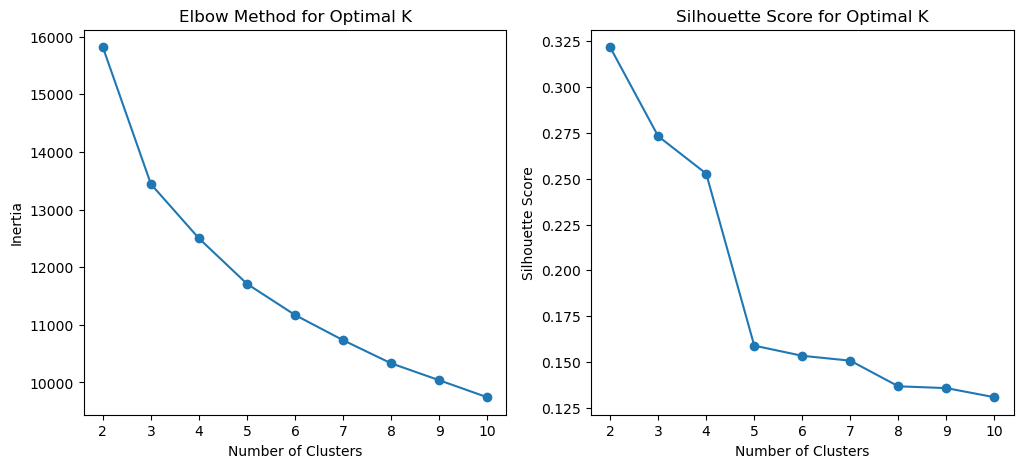

In [26]:
# Determine the optimal number of clusters using the elbow method
inertia = []
silhouette_scores = []
K_range = range(2, 11)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(df_scaled)
    inertia.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(df_scaled, kmeans.labels_))

# Plot the elbow method
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(K_range, inertia, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal K')

# Plot silhouette scores
plt.subplot(1, 2, 2)
plt.plot(K_range, silhouette_scores, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for Optimal K')

plt.show()

* The elbow method and silhouette score plots suggest that an optimal number of clusters is around 3 to 4, as indicated by the inflection point in the inertia plot and the peak silhouette score.

* We will proceed with applying K-Means clustering using 3 clusters and analyze the resulting customer segments.

In [27]:
# Apply K-Means clustering with the chosen number of clusters
optimal_k = 3
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
df_encoded['Cluster_Kmeans'] = kmeans.fit_predict(df_scaled)
silhouette_kmeans = silhouette_score(df_scaled, df_encoded['Cluster_Kmeans'])
db_score_kmeans = davies_bouldin_score(df_scaled, df_encoded['Cluster_Kmeans'])

# Apply DBSCAN Clustering
dbscan_model = DBSCAN(eps=0.8, min_samples=10)
df_encoded['Cluster_DBSCAN'] = dbscan_model.fit_predict(df_scaled)
silhouette_dbscan = silhouette_score(df_scaled, df_encoded['Cluster_DBSCAN']) if len(set(dbscan_model.labels_)) > 1 else None
db_score_dbscan = davies_bouldin_score(df_scaled, df_encoded['Cluster_DBSCAN']) if len(set(dbscan_model.labels_)) > 1 else None

# Apply Agglomerative Clustering
agglo_model = AgglomerativeClustering(n_clusters=3)
df_encoded['Cluster_Agglo'] = agglo_model.fit_predict(df_scaled)
silhouette_agglo = silhouette_score(df_scaled, df_encoded['Cluster_Agglo'])
db_score_agglo = davies_bouldin_score(df_scaled, df_encoded['Cluster_Agglo'])

# Compare clustering performance
clustering_comparison = pd.DataFrame({
    "Model": ["K-Means", "DBSCAN", "Agglomerative"],
    "Silhouette Score": [silhouette_kmeans, silhouette_dbscan, silhouette_agglo],
    "Davies-Bouldin Score": [db_score_kmeans, db_score_dbscan, db_score_agglo]
})

clustering_comparison

,Model,Silhouette Score,Davies-Bouldin Score
0,K-Means,0.273166,1.549375
1,DBSCAN,-0.164827,1.421889
2,Agglomerative,0.237704,1.567222


Based on the Silhouette Score and the Davies-Bouldin Score, the best model is the K-Means clustering model

In [28]:
# Analyze the isclusters in the K-Means clustering method
cluster_summary = df_encoded.groupby('Cluster_Kmeans')[clustering_features].mean()
cluster_summary

,Income,Recency,Num_Deals_Purchases,Num_Web_Purchases,Num_Catalog_Purchases,Num_Store_Purchases,Num_Web_Visits_Month,Total_Purchase,Age,Total_Spending,Num_Of_Child
Cluster_Kmeans,,,,,,,,,,,
0,55758.473684,49.407018,4.263158,6.519298,2.808772,7.461404,6.280702,21.052632,36.789474,711.214035,1.264912
1,34389.403015,48.977889,1.894472,2.017085,0.530653,3.176884,6.397990,7.619095,37.162814,94.729648,1.212060
2,75653.037152,48.888545,1.263158,5.117647,5.839009,8.379257,2.811146,20.599071,37.142415,1314.193498,0.261610


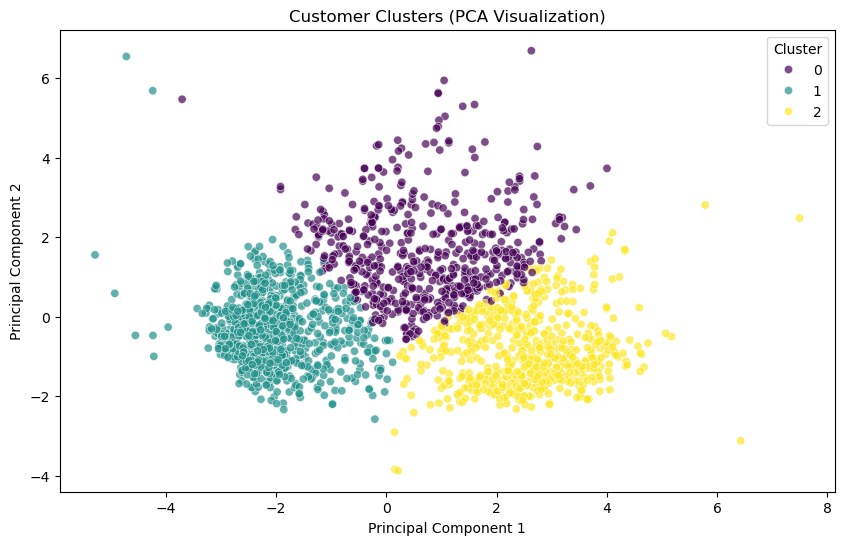

C:\Users\admin\AppData\Local\Temp\ipykernel_20460\189148849.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df_encoded['Cluster'], palette='pastel')


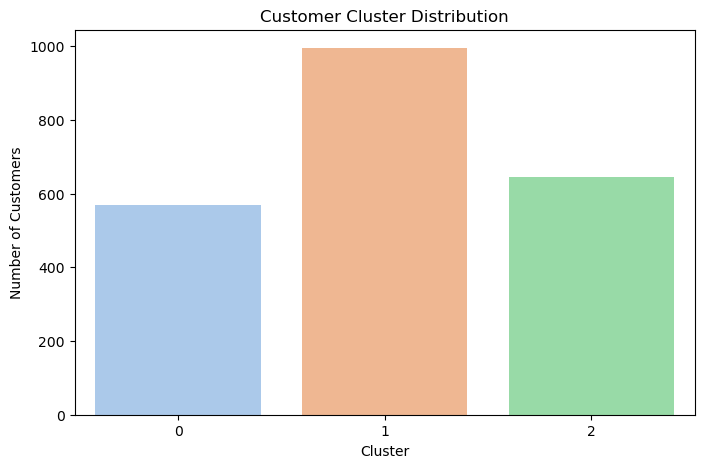

C:\Users\admin\AppData\Local\Temp\ipykernel_20460\189148849.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Cluster', y=feature, data=df_encoded, palette='Set2')


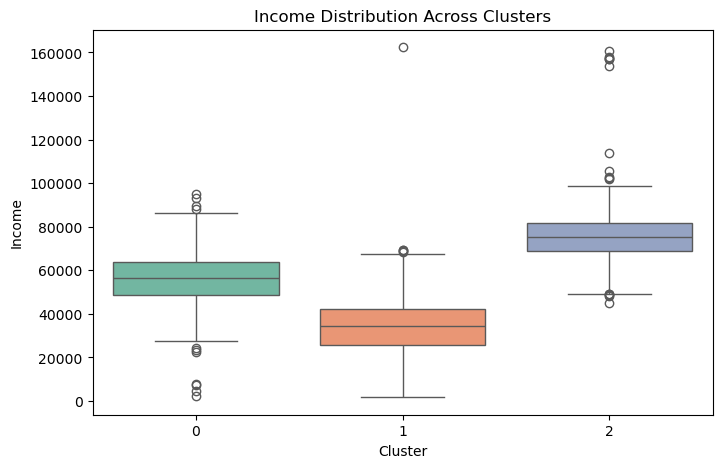

C:\Users\admin\AppData\Local\Temp\ipykernel_20460\189148849.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Cluster', y=feature, data=df_encoded, palette='Set2')


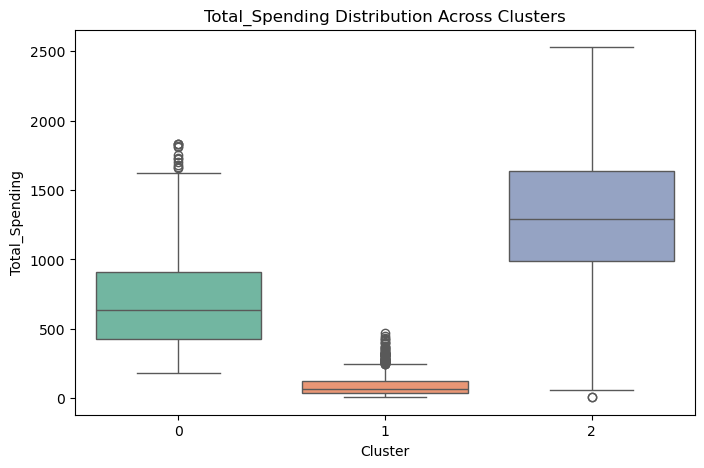

C:\Users\admin\AppData\Local\Temp\ipykernel_20460\189148849.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Cluster', y=feature, data=df_encoded, palette='Set2')


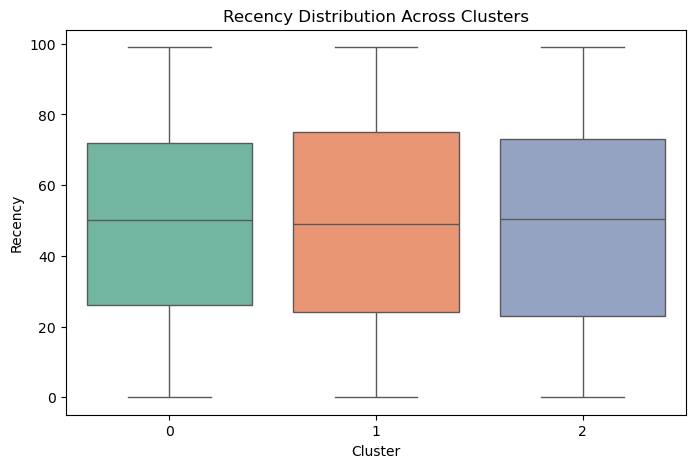

C:\Users\admin\AppData\Local\Temp\ipykernel_20460\189148849.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Cluster', y=feature, data=df_encoded, palette='Set2')


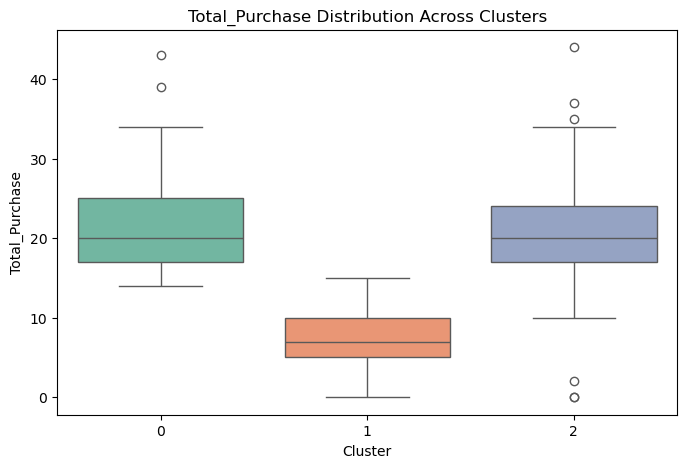

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns

# Add cluster labels to the original dataset
df_encoded['Cluster'] = kmeans.labels_

# Scatter plot using PCA components
plt.figure(figsize=(10, 6))
sns.scatterplot(x=df_pca[:, 0], y=df_pca[:, 1], hue=df_encoded['Cluster'], palette='viridis', alpha=0.7)
plt.title('Customer Clusters (PCA Visualization)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Cluster')
plt.show()

# Bar chart of cluster counts
plt.figure(figsize=(8, 5))
sns.countplot(x=df_encoded['Cluster'], palette='pastel')
plt.title('Customer Cluster Distribution')
plt.xlabel('Cluster')
plt.ylabel('Number of Customers')
plt.show()

# Box plots for key numerical features across clusters
features_to_plot = ['Income', 'Total_Spending', 'Recency', 'Total_Purchase']

for feature in features_to_plot:
    plt.figure(figsize=(8, 5))
    sns.boxplot(x='Cluster', y=feature, data=df_encoded, palette='Set2')
    plt.title(f'{feature} Distribution Across Clusters')
    plt.xlabel('Cluster')
    plt.ylabel(feature)
    plt.show()


#### 1. Scatter Plot (PCA Visualization):
* The three clusters are well-separated, suggesting distinct customer segments.
* Cluster 0 and Cluster 2 are more distinct, while Cluster 1 overlaps slightly with the others, indicating some similarities.

#### 2. Cluster Distribution (Bar Chart):
* The distribution shows an imbalance in cluster sizes, with one cluster having a significantly higher number of customers.
* Cluster 1 has the highest number of customers, suggesting it may contain general or average customers.

#### 3. Box Plot Insights<br>
<b>Income Distribution Across Clusters:</b><br>
* Cluster 2 has the highest median income, indicating high-income customers.<br>
* Cluster 1 represents lower-income customers compared to others.<br>
* Cluster 0 falls in the mid-range income group.
<br><br>
<b>Total Spending Across Clusters:</b><br>
* Cluster 2 spends significantly more compared to the other clusters.<br>
* Cluster 1 has the lowest spending, suggesting budget-conscious customers.<br>
* Cluster 0 represents moderate spenders.
<br><br>
<b>Recency (Last Purchase Time) Across Clusters:</b><br>
* Cluster 1 has the highest recency values, implying they haven't made purchases recently and may be at risk of churn.<br>
* Cluster 2 has the lowest recency values, indicating frequent, engaged customers.<br>
* Cluster 0 lies in between, with moderate engagement levels.
<br><br>
<b>Total Purchases Across Clusters:</b><br>
* Cluster 2 has the highest number of total purchases, showing strong loyalty.<br>
* Cluster 1 has the lowest, reinforcing the idea of disengagement.<br>
* Cluster 0 represents customers with moderate purchase activity.

### Key Insights and Recommendations:
1. High-Value Customers (Cluster 2):
* High income, high spending, and frequent purchases.<br>
* Retention strategies should focus on premium services, exclusive offers, and loyalty rewards.

2. Moderate Customers (Cluster 0):
* Balanced spending and purchase frequency.<br>
* Engagement strategies like personalized recommendations and seasonal promotions can drive more purchases.

3. Potential Churners (Cluster 1):
* Low spending, infrequent purchases, and high recency.<br>
* Requires re-engagement strategies such as special discounts, targeted emails, and reminders to bring them back.

In [30]:
# Selecting product-related features
product_features = ["Liquor", "Vegetables", "Pork", "Seafood", "Candy", "Jewellery"]

# Convert product data to boolean type for Apriori analysis
df_products = df_encoded[product_features].apply(lambda x: x > 0).astype(bool)

# Apply the Apriori algorithm to find frequent itemsets
frequent_itemsets = apriori(df_products, min_support=0.05, use_colnames=True)

# Manual extraction of association rules
def generate_rules(frequent_itemsets, min_confidence=0.5):
    rules = []
    for _, row in frequent_itemsets.iterrows():
        items = row['itemsets']
        support = row['support']
        if len(items) > 1:
            for antecedent in combinations(items, len(items) - 1):
                consequent = items - set(antecedent)
                antecedent_support = frequent_itemsets[
                    frequent_itemsets['itemsets'] == set(antecedent)
                ]['support'].values[0]
                confidence = support / antecedent_support
                if confidence >= min_confidence:
                    rules.append({
                        'Antecedents': antecedent,
                        'Consequents': consequent,
                        'Support': support,
                        'Confidence': confidence,
                        'Lift': confidence / (frequent_itemsets[
                            frequent_itemsets['itemsets'] == consequent
                        ]['support'].values[0])
                    })
    return pd.DataFrame(rules)

# Generate association rules manually
rules_df = generate_rules(frequent_itemsets, min_confidence=0.6)

# Sort by confidence and display
rules_df = rules_df.sort_values(by='Confidence', ascending=False)

print(rules_df[['Antecedents', 'Consequents', 'Support', 'Confidence', 'Lift']])

                    Antecedents   Consequents   Support  Confidence      Lift
0                     (Liquor,)  (Vegetables)  1.000000    1.000000  1.000000
102    (Candy, Liquor, Seafood)  (Vegetables)  0.733605    1.000000  1.000000
36              (Candy, Liquor)  (Vegetables)  0.813659    1.000000  1.000000
37          (Candy, Vegetables)      (Liquor)  0.813659    1.000000  1.000000
120  (Pork, Jewellery, Seafood)      (Liquor)  0.810493    1.000000  1.000000
..                          ...           ...       ...         ...       ...
7                     (Liquor,)       (Candy)  0.813659    0.813659  1.000000
97   (Pork, Liquor, Vegetables)       (Candy)  0.813207    0.813575  0.999896
65           (Pork, Vegetables)       (Candy)  0.813207    0.813575  0.999896
21                      (Pork,)       (Candy)  0.813207    0.813575  0.999896
47               (Pork, Liquor)       (Candy)  0.813207    0.813575  0.999896

[186 rows x 5 columns]


## Key Insights from the Output:
### 1. Strong Associations (High Confidence and Support):
* The top rule (Liquor → Vegetables) has a confidence of 1.000000 and support of 1.000000, meaning every customer who buys liquor also buys vegetables.<br>
* Similar strong relationships exist for (Pork, Candy) → Liquor and (Jewellery, Vegetables, Seafood) → Liquor, indicating these product combinations should be considered for placement together.
<br>
### 2. Frequent Item Combinations:
* Items like Liquor, Vegetables, and Pork frequently appear in combination with other products, suggesting they are popular choices among customers.<br>
* Grouping these products in adjacent aisles may encourage larger purchases.
<br>
### 3. Opportunities for Bundling:
* Since combinations like (Liquor, Pork) → Candy have high confidence (~81.36%), bundling promotions for these items might drive more sales.<br>
* Placement of these items in proximity could optimize store layout.
<br>
### 4. Rules with Lower Lift Values (~0.999896):
* Some rules, such as (Liquor, Pork) → Candy, show slightly lower lift values, meaning the association might not be strong enough to drive a placement decision, but they still occur frequently.

## Recommendations for Store Setup:
### 1. Product Placement:
* Place strongly associated items (e.g., Liquor and Vegetables) together in the store to encourage cross-selling.
* High-confidence item pairs should be positioned near checkout areas for impulse purchases.

### 2. Cross-Promotions:
* Consider running promotions like discounts on Vegetables when customers buy Liquor, given their 100% association rate.

### 3. Inventory Management:
Stock high-frequency pairs in larger quantities to avoid shortages and meet demand efficiently.